## Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as CM
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset
from sleeprnn.helpers.reader import RefactorUnpickler
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys, viz

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
CUSTOM_COLOR = viz.PALETTE
viz.notebook_full_width()

In [2]:
ckpt_dict = {
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_ss', 'v19'): [0.54, 0.52, 0.64, 0.54],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_ss', 'v11'): [0.48, 0.5, 0.56, 0.3],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_ss', 'v21'): [0.3, 0.62, 0.64, 0.54],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_kc', 'v19'): [0.54, 0.64, 0.52, 0.5],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_kc', 'v21'): [0.56, 0.32, 0.52, 0.56],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_kc', 'v11'): [0.56, 0.34, 0.64, 0.52],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_inta_ss', 'v19'): [0.42, 0.42, 0.46, 0.44],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_inta_ss', 'v21'): [0.44, 0.4, 0.48, 0.46],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_inta_ss', 'v11'): [0.48, 0.42, 0.42, 0.44],
    os.path.join('20190827_thesis_1_bsf_e2_n2_train_mass_ss', 'v19'): [0.58, 0.5, 0.34, 0.6],
    os.path.join('20190827_thesis_1_bsf_e2_n2_train_mass_ss', 'v21'): [0.5, 0.58, 0.56, 0.48],
    os.path.join('20190827_thesis_1_bsf_e2_n2_train_mass_ss', 'v11'): [0.52, 0.6, 0.54, 0.5]
}

## Performance Results - Ablation

In [3]:
data_selected = 3

dataset_name_expert_list = [
    (constants.MASS_SS_NAME, 1),
    (constants.MASS_SS_NAME, 2),
    (constants.MASS_KC_NAME, 1),
    (constants.INTA_SS_NAME, 1)
]
model_name_list = [
    'v11',
    'v19',
    'v21'
]
model_name_display_dict = {
    'v11': 'Time Domain Model',
    'v19': 'CWT Domain Model',
    'v21': 'Combined Model'}

dataset_name = dataset_name_expert_list[data_selected][0]
which_expert = dataset_name_expert_list[data_selected][1]
task_mode = constants.N2_RECORD
n_seeds = 4

dataset = load_dataset(dataset_name)
test_ids = dataset.test_ids
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()

predictions_dict = {}
optimal_thr_dict = {}
for model_name in model_name_list:
    predictions_dict[model_name] = []
    optimal_thr_dict[model_name] = []
    useful_keys = [key for key in ckpt_dict.keys() if dataset_name in key and ('e%d' % which_expert) in key and model_name in key]
    # Read predictions
    for key in useful_keys:
        for k in range(n_seeds):
            ckpt_path = os.path.abspath(os.path.join(RESULTS_PATH, 'predictions_%s' % dataset_name, key, 'seed%d' % k))
            filename = os.path.join(ckpt_path, 'prediction_%s_test.pkl' % task_mode)
            with open(filename, 'rb') as handle:
                this_pred = RefactorUnpickler(handle).load()
            predictions_dict[model_name].append(this_pred)
            optimal_thr_dict[model_name].append(ckpt_dict[key][k])
print('Predictions loaded')

Train size: 7. Test size: 3
Train subjects: 
 [1, 2, 4, 6, 8, 10, 11]
Test subjects: 
 [5, 7, 9]
Dataset inta_ss with 10 patients.
Loading from checkpoint... Loaded
Global STD: 39.144096
Predictions loaded


In [4]:
# Measure AF1 and F1 vs IoU
print('Measuring F1')
af1_dict = {}
f1_vs_iou_dict = {}
iou_at_tp_dict = {}
iou_list = np.arange(1, 10) * 0.1
iou_idx_to_show = 1
round_precision = 2
for model_name in model_name_list:
    print('Measuring model %s' % model_name, flush=True)
    af1_dict[model_name] = []
    f1_vs_iou_dict[model_name] = []
    iou_at_tp_dict[model_name] = []
    for optimal_thr, predictions in zip(optimal_thr_dict[model_name], predictions_dict[model_name]):
        predictions.set_probability_threshold(optimal_thr)
        this_detections = predictions.get_stamps()
        af1_at_thr = metrics.average_metric_with_list(this_events, this_detections, verbose=False)
        af1_dict[model_name].append(af1_at_thr)
        this_f1_vs_iou = metrics.metric_vs_iou_with_list(this_events, this_detections, iou_list)
        f1_vs_iou_dict[model_name].append(this_f1_vs_iou)
        
        # Measure mean IoU at TP
        mean_iou_per_subject = []
        for single_events, single_detections in zip(this_events, this_detections):
            this_iou_array, idx_array = metrics.matching(single_events, single_detections)
            this_iou_array = this_iou_array[idx_array > -1]
            mean_iou_per_subject.append(np.mean(this_iou_array))
        iou_at_tp_dict[model_name].append(np.mean(mean_iou_per_subject))
        
# Mean results
mean_af1_dict = {}
mean_f1_vs_iou_dict = {}
for model_name in model_name_list:
    mean_af1 = np.mean(af1_dict[model_name])
    std_af1 = np.std(af1_dict[model_name])
    
    mean_curve = np.stack(f1_vs_iou_dict[model_name], axis=1).mean(axis=1)
    std_curve = np.stack(f1_vs_iou_dict[model_name], axis=1).std(axis=1)
    
    mean_af1_dict[model_name] = (mean_af1, std_af1)
    mean_f1_vs_iou_dict[model_name] = (mean_curve, std_curve)
    
    print('%s F1 at IoU %1.1f: %1.2f +- %1.2f' 
          % ( model_name_display_dict[model_name].ljust(20), iou_list[iou_idx_to_show],
              np.round(100*mean_curve[iou_idx_to_show], decimals=round_precision), 
              np.round(100*std_curve[iou_idx_to_show], decimals=round_precision)))
    
    
print('Done')

print('\nTest AF1 for %s' % dataset_name)
for model_name in model_name_list:
    print('%s: %1.2f +- %1.2f' 
          % (
              model_name_display_dict[model_name].ljust(20), 
              np.round(100*mean_af1_dict[model_name][0], decimals=round_precision), 
              np.round(100*mean_af1_dict[model_name][1], decimals=round_precision)))
    
print('\nMean IoU at TP for %s' % dataset_name)
for model_name in model_name_list:
    print('%s: %1.2f +- %1.2f' 
          % (
              model_name_display_dict[model_name].ljust(20), 
              np.round(100*np.mean(iou_at_tp_dict[model_name]), decimals=round_precision), 
              np.round(100*np.std(iou_at_tp_dict[model_name]), decimals=round_precision)))

Measuring F1
Measuring model v11
Measuring model v19
Measuring model v21
Time Domain Model    F1 at IoU 0.2: 80.50 +- 0.81
CWT Domain Model     F1 at IoU 0.2: 81.16 +- 0.62
Combined Model       F1 at IoU 0.2: 80.77 +- 0.65
Done

Test AF1 for inta_ss
Time Domain Model   : 58.02 +- 0.61
CWT Domain Model    : 58.28 +- 0.60
Combined Model      : 58.22 +- 0.56

Mean IoU at TP for inta_ss
Time Domain Model   : 71.30 +- 0.12
CWT Domain Model    : 71.05 +- 0.33
Combined Model      : 71.27 +- 0.40


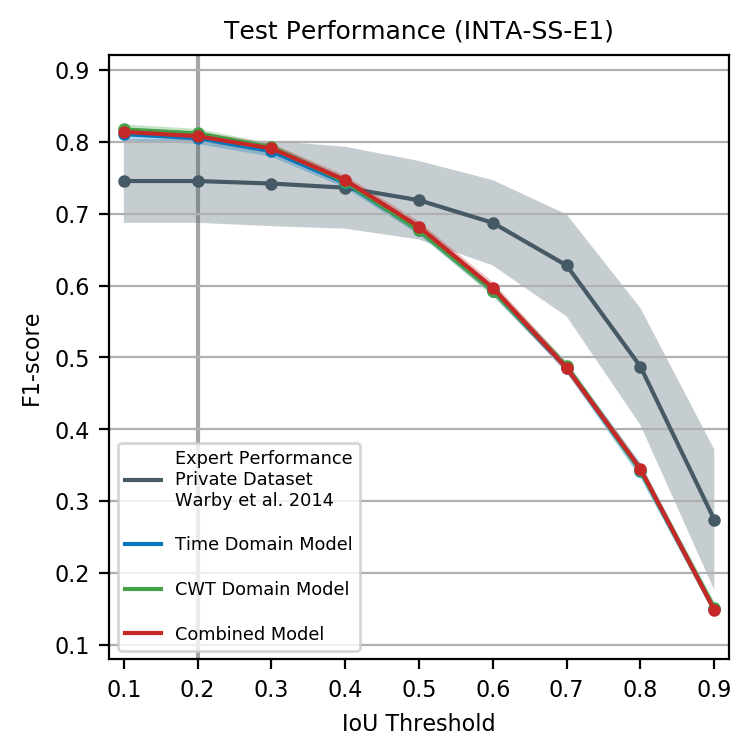

In [5]:
alpha = 0.3
color_list = {'v21': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'v11': CUSTOM_COLOR['blue'], 'v19': CUSTOM_COLOR['green']}
linewidth = 1.5
markersize = 7
title_fontsize = 9
other_fontsize = 8
show_std = True

# -------------------- P L O T ----------------------    

# Comparison data
compare_expert = dataset.event_name == constants.SPINDLE
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_std.csv'), delimiter=',')
    expert_f1_curve_mean = expert_f1_curve_mean[1:, :]
    expert_f1_curve_std = expert_f1_curve_std[1:, :]
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=viz.DPI)

# Complete plot
if compare_expert:
    ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linewidth=linewidth, 
               label='Expert Performance\nPrivate Dataset\nWarby et al. 2014', color=color_list['expert'])
    ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linestyle='none', 
               markersize=markersize, marker='.', color=color_list['expert'])
    ax.fill_between(
        expert_f1_curve_mean[:, 0], 
        expert_f1_curve_mean[:, 1] - expert_f1_curve_std[:, 1], 
        expert_f1_curve_mean[:, 1] + expert_f1_curve_std[:, 1], 
        alpha=alpha, facecolor=color_list['expert'])

for model_name in model_name_list:
    this_name = model_name_display_dict[model_name]
    ax.plot(iou_list, mean_f1_vs_iou_dict[model_name][0], 
               linewidth=linewidth,
               label='%s' % this_name, color=color_list[model_name])
    ax.plot(iou_list, mean_f1_vs_iou_dict[model_name][0], 
               linestyle='none', markersize=markersize, marker='.', 
               color=color_list[model_name])
    if show_std:
        ax.fill_between(iou_list, 
                        mean_f1_vs_iou_dict[model_name][0] - mean_f1_vs_iou_dict[model_name][1], 
                        mean_f1_vs_iou_dict[model_name][0] + mean_f1_vs_iou_dict[model_name][1], alpha=alpha, facecolor=color_list[model_name])


    
ax.set_title('Test Performance (%s-%s-E%d)' % (dataset_name.upper()[:-3], dataset_name.upper()[-2:], which_expert), fontsize=title_fontsize)
ax.set_xlim([0.1 - 0.02, 0.9 + 0.02])
ax.set_ylim([0.1 - 0.02, 0.9 + 0.02])
# ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=other_fontsize)
ax.set_xlabel('IoU Threshold', fontsize=other_fontsize)
ax.set_ylabel('F1-score', fontsize=other_fontsize)
ax.yaxis.grid()
ax.plot([iou_list[iou_idx_to_show], iou_list[iou_idx_to_show]], [0, 1], zorder=0, color='grey', alpha=0.7)
ax.legend(loc='lower left', labelspacing=1.5, fontsize=0.8*other_fontsize)

plt.show()

In [12]:
# PR
iou_thr = iou_list[iou_idx_to_show]
res_thr = 0.02
start_thr = 0.1
end_thr = 0.9
n_thr = int(np.round((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])

pr_curve_dict = {}
for model_name in model_name_list:
    print('Measuring model %s' % model_name, flush=True)
    pr_curve_dict[model_name] = []
    for k, predictions in enumerate(predictions_dict[model_name]):
        pr_curve_dict[model_name].append(np.zeros((n_thr, 2)))
        for i, thr in enumerate(thr_list):
            predictions.set_probability_threshold(thr)
            this_detections = predictions.get_stamps()
            this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                        for (this_y, this_y_pred) in zip(this_events, this_detections)]
            this_recall = np.mean([m[constants.RECALL] for m in this_stats])
            this_precision = np.mean([m[constants.PRECISION] for m in this_stats])
            pr_curve_dict[model_name][k][i, 0] = this_recall
            pr_curve_dict[model_name][k][i, 1] = this_precision
print('Done', flush=True)

Measuring model v11
Measuring model v19
Measuring model v21
Done


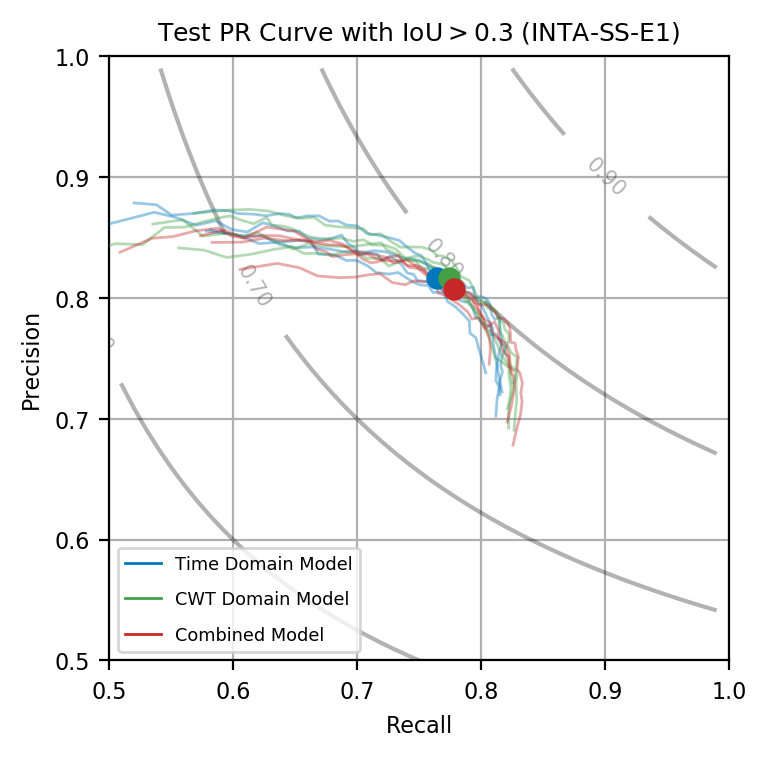

In [13]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=viz.DPI)
markersize = 6
alpha = 0.4
text_space = 0.01
compare_expert = dataset.event_name == constants.SPINDLE
axis_lims = [0.5, 1.0]
color_list = {'v21': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'v11': CUSTOM_COLOR['blue'], 'v19': CUSTOM_COLOR['green']}
title_fontsize = 9
other_fontsize = 8

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')
    
if compare_expert:
    expert_pr_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_pr_expert_mean.csv'), delimiter=',')
    ax.scatter(expert_pr_mean[0], expert_pr_mean[1], s=50, c=color_list['expert'], zorder=10, label='Expert Performance\nPrivate Dataset\nWarby et al. 2014')
    
for model_name in model_name_list:
    mean_precision = []
    mean_recall = []
    for k, pr_curve in enumerate(pr_curve_dict[model_name]):
        if k == 0:
            label = model_name_display_dict[model_name]
        else:
            label = None
        thr_run = optimal_thr_dict[model_name][k]
        chosen_thr_idx = np.where(np.isclose(thr_list, thr_run))[0].item()
        ax.plot(pr_curve[:, 0], pr_curve[:, 1], linewidth=1, color=color_list[model_name], zorder=7, alpha=alpha, label=label)
        mean_precision.append(pr_curve[chosen_thr_idx, 1])
        mean_recall.append(pr_curve[chosen_thr_idx, 0])
    mean_precision = np.mean(mean_precision)
    mean_recall = np.mean(mean_recall)
    ax.scatter(mean_recall, mean_precision, s=50, c=color_list[model_name], zorder=10)

ax.set_title('Test PR Curve with IoU$>$%1.1f (%s-%s-E%d)' % (iou_thr, dataset_name.upper()[:-3], dataset_name.upper()[-2:], which_expert), fontsize=title_fontsize)
ax.set_xlabel('Recall', fontsize=other_fontsize)
ax.set_ylabel('Precision', fontsize=other_fontsize)
ax.set_xlim(axis_lims)
ax.set_ylim(axis_lims)

lg = ax.legend(loc='lower left', labelspacing=1, fontsize=0.8*other_fontsize)
for lh in lg.legendHandles:
    lh.set_alpha(1.0)

ax.tick_params(labelsize=other_fontsize)
ax.grid()
plt.show()

## SS and KC example

In [8]:
subject_id = 1
dataset = load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482037
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482037
1044 SS stamps.
409 KC stamps.


In [9]:
def filter_stamps(stamps, start_sample, end_sample):
    pages_list = []
    for i in range(stamps.shape[0]):
        start_inside = (stamps[i, 0] > start_sample) and (stamps[i, 0] < end_sample)
        end_inside = (stamps[i, 1] > start_sample) and (stamps[i, 1] < end_sample)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list

In [10]:
def plot_segment(which_kc_stamp):
    left_context = 2.8
    right_context = 7.2
    segment_size = left_context + right_context
    central_sample = stamps_kc[which_kc_stamp, :].mean()
    start_sample = int(central_sample - fs * left_context)
    end_sample = int(central_sample + fs * right_context)

    segment_stamps_ss = filter_stamps(stamps_ss, start_sample, end_sample)
    segment_stamps_kc = filter_stamps(stamps_kc, start_sample, end_sample)
    segment_signal = signal[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs

    title_fontsize = 9
    other_fontsize = 8
    fig, ax = plt.subplots(1, 1, dpi=viz.DPI, figsize=(4, 2))

    y_max = 200
    y_mark = -130
    ax.plot(
        time_axis, segment_signal, 
        linewidth=0.8, color=CUSTOM_COLOR['grey'], label='EEG Signal')
    stamp_label_used = False
    for stamp in segment_stamps_ss:
        if stamp_label_used:
            label = None
        else:
            label = 'Sleep Spindle'
            stamp_label_used = True
#       ax.plot(stamp/fs, [y_mark, y_mark], label=label, linewidth=1.5, color=CUSTOM_COLOR['red'])
        ax.fill_between(
            stamp / fs, y_mark, -y_mark, 
            facecolor=CUSTOM_COLOR['red'], alpha=0.3, label=label,
            # edgecolor='k', 
            linewidth=1.5, 
        )
    stamp_label_used = False
    for stamp in segment_stamps_kc:
        if stamp_label_used:
            label = None
        else:
            label = 'K-Complex'
            stamp_label_used = True
#        ax.plot(stamp/fs, [y_mark, y_mark], label=label, linewidth=1.5, color=CUSTOM_COLOR['blue'])
        ax.fill_between(
            stamp / fs, y_mark, -y_mark, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            # edgecolor='k', 
            linewidth=1.5, 
        )
    ax.set_xlabel('Time [s] (intervals of 0.5s shown)', fontsize=other_fontsize)
    ax.set_ylabel('Voltage [$\mu$V]', fontsize=other_fontsize)
    # ax.set_yticks([-y_max, 0, y_max])
    ax.set_yticks([])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylim([-y_max, y_max])
    # ticks_array = time_axis[0] + np.arange(0, segment_size+1, 5)
    # ax.set_xticks(ticks_array)
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper center', fontsize=other_fontsize-1)
    ax.tick_params(labelsize=other_fontsize)
    plt.show()

In [11]:
widgets.interact(
    lambda which_kc_stamp: plot_segment(which_kc_stamp),
    which_kc_stamp=widgets.IntSlider(min=0,max=stamps_kc.shape[0]-1,step=1,value=195, continuous_update=False));

interactive(children=(IntSlider(value=195, continuous_update=False, description='which_kc_stamp', max=408), Ou…